# Perfectly Known Spinning-Down Signals

At this point we think that we have built enough insight to test seeking a *known* spinning down signal using the template method. The method has been shown to work on single SFTs so now we want to look at combining the results from several SFTs. As usual, a signal is characterized by the constant parameters, a complex amplitude $A$, an initial frequency $f_0$ or $\omega_0$, and a rate of change of frequency, $\dot{f}$ or $\dot{\omega}$.

I am going to stick to the relatively small models that I have been using and leave Clare to the multi-day models that represent real data. I will use 1,000 samples/second (1 ksps) and 10 total seconds of data split across ten 1\,s frames. This means that my SFTs will have a bin spacing of 1 Hz. I will start with a signal $A=1+0i$, $f_0=50\,$Hz, and $\dot{f}=-0.5\,$Hz/s, so that within one 1\,s frame the frequency will have fallen by half a frequency bin.

As usual, we will need some tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Signal

Then I build the signal, which will also become the source of the template.

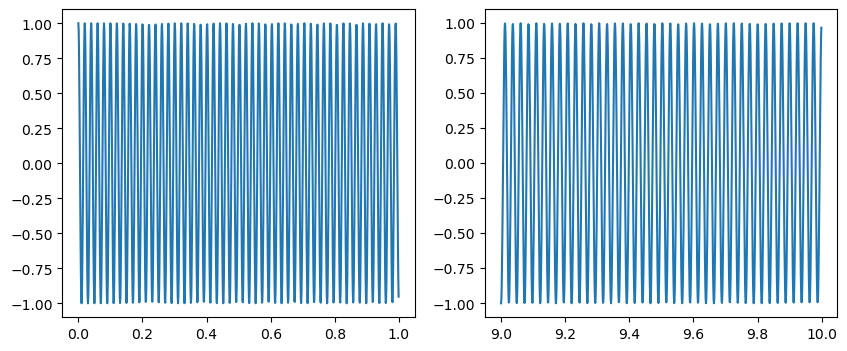

In [2]:
rate=1_000
duration=10
nSample = rate * duration
time = np.linspace(0, duration, num=nSample, endpoint=False)
freq0 = 50.0
freqDot = -0.5
w0 = 2 * np.pi * freq0
wDot = 2 * np.pi * freqDot
sig = np.cos((w0 + wDot * time) * time)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.plot(time[:1000], sig[:1000])
ax2 = fig.add_subplot(122)
ax2.plot(time[-1000:], sig[-1000:])


Looking carefully you can see that the final second has a smaller number of periods than the initial second.

## The Templates

Next we split this up into ten frames and form the short Fourier Transforms (SFTs). We make a separate copy of the SFTs to use as the template and normalize that template to a total energy of 1.

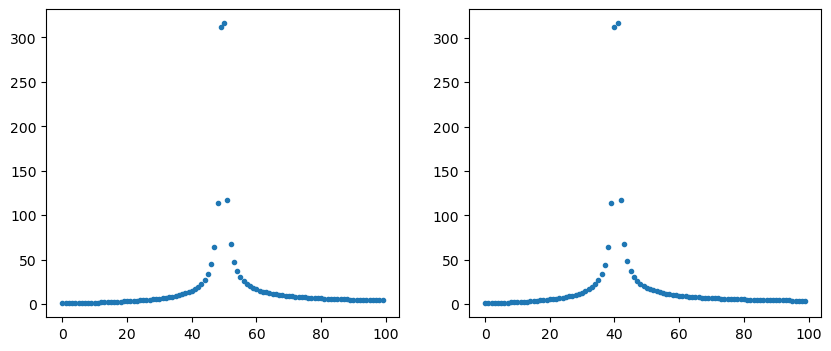

In [3]:
nFrame = 10
nShort = int(nSample / nFrame)
frames = np.reshape(sig, (nFrame, nShort), order='A')
SFTs = np.fft.rfft(frames, axis=1)
nFreq = SFTs.shape[1]
shortFreq = np.linspace(0, 1/(time[2]-time[0]), num=nFreq)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
plt.plot(shortFreq[:100], np.absolute(SFTs[0, :100]), '.')
ax2 = fig.add_subplot(122)
plt.plot(shortFreq[:100], np.absolute(SFTs[9, :100]), '.')


Here we nicely see that the center frequency in the last second is about 10 Hz lower than the center frequnecy in the first second, exactly as we expect.

Now we re-normalize these SFTs to form the templates.

In [4]:
totals = np.sum(SFTs.conjugate() * SFTs, axis=1)
print(totals)

[250001.00037394-2.74916016e-12j 250001.00041487+9.94532233e-13j
 250001.00046084+1.16666234e-12j 250001.00051259-1.29188280e-12j
 250001.00057095+1.12785649e-12j 250001.00063692+1.69765424e-12j
 250001.00071166-1.65073857e-12j 250001.00079656-1.36042294e-12j
 250001.00089321+3.92659915e-12j 250001.00100358-4.43068889e-12j]


In [5]:
templates = SFTs.copy()
for frame in range(nFrame):
    templates[frame, :] /= np.sqrt(totals[frame])
print(np.sum(templates.conjugate() * templates, axis=1))

[1.-1.21304741e-17j 1.-5.56787209e-18j 1.-1.87893185e-17j
 1.-1.74007519e-17j 1.+1.56457610e-17j 1.+9.17362850e-18j
 1.-1.21094865e-17j 1.-5.99206576e-18j 1.-1.30633831e-19j
 1.-1.92085654e-18j]


and there we have verified that the templates all have the desired normalization, to within rounding error.

## Summing the Bins

We can now use the templates to form the templated average signals, the $z_n$s, given by
$$z_n = \sum_{j=1}^{N}h_{j, n} t_{j, n}^{*},$$
where $h_{j, n}$ is the complex signal value in the j'th frequency bin of the n'th frame and $t_{j, n}$ is the template value in the corresponding location.

In [6]:
zns = np.sum(templates.conjugate() * SFTs, axis=1)
print(zns)

[500.00100037-5.83902096e-15j 500.00100041+6.87540465e-15j
 500.00100046-7.70695897e-15j 500.00100051+1.54117362e-14j
 500.00100057+1.05821040e-14j 500.00100064-1.25852612e-14j
 500.00100071-4.43594429e-15j 500.0010008 -1.37978157e-14j
 500.00100089-3.23993528e-14j 500.001001  -5.95878236e-15j]


Because we have used the exact noise-free signal corresponding to the template, we have a set of ten identical, real, values each appropriate to an $A=1$ on a bin edge. The method has worked as well as possible. We then extract the power by summing the squares of these.

In [7]:
totPower = np.sum(zns.conjugate() * zns)
print(totPower)

(2500010.006375124-8.281621854198644e-28j)


The ideal value would be 2,500,010 so that we have errors at the few parts in $10^9$ level, quite reasonable for double precision arithmetic.

## Imperfect Signal

What if we get the wrong signal parameters? Let's try shifting the center frequency by half a bin and repeating the analysis.

In [8]:
freq1 = 50.5
freqDot = -0.5
w1 = 2 * np.pi * freq1
wDot = 2 * np.pi * freqDot
sig1 = np.cos((w1 + wDot * time) * time)

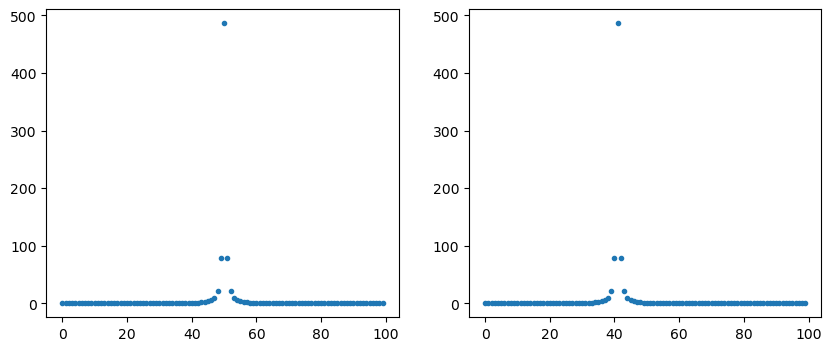

In [9]:
frames1 = np.reshape(sig1, (nFrame, nShort), order='A')
SFTs1 = np.fft.rfft(frames1, axis=1)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
plt.plot(shortFreq[:100], np.absolute(SFTs1[0, :100]), '.')
ax2 = fig.add_subplot(122)
plt.plot(shortFreq[:100], np.absolute(SFTs1[9, :100]), '.')

We see that the SFTs have shifted appropriately.

Now we analyze these *with the original templates*.

In [10]:
zns1 = np.sum(templates.conjugate() * SFTs1, axis=1)
print(zns1)
totPower1 = np.sum(zns1.conjugate() * zns1)
print(totPower1)

[ 0.99994659+319.86256306j -0.99994335-319.89656949j
  0.99993984+319.9319548j  -0.99993603-319.96880752j
  0.99993187+320.00722396j -0.99992733-320.04730901j
  0.99992237+320.08917716j -0.99991693-320.1329536j
  0.99991096+320.17877553j -0.99990438-320.2267936j ]
(1024229.1068045972-5.805356235545483e-14j)


So even that half-bin shift has pulled the total power down by a factor of nearly 2.5. This is pretty good adjacent channel rejection.

## Again with Noise

Let's try the same process with our usual oversized noise added.

In [11]:
rng = np.random.default_rng()
noise = rng.uniform(low=-10.0, high=10.0, size=nSample)
nSig = noise + sig

Just out of interest let's look at the long-time FT.

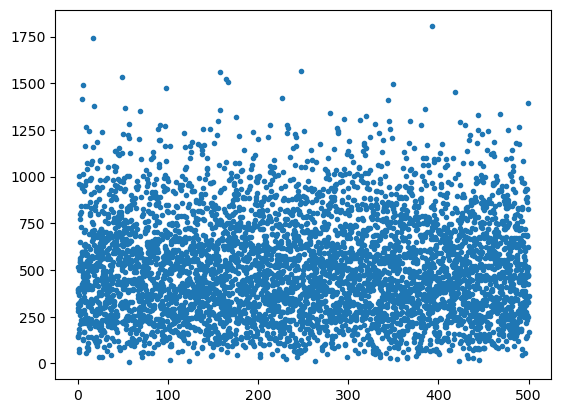

In [12]:
lFT = np.fft.rfft(nSig)
nlFreq = lFT.shape[0]
longFreq = np.linspace(0, 1/(time[2]-time[0]), num=nlFreq)
plt.plot(longFreq, np.absolute(lFT), '.')

Interestingly the largest peak is up near 300 Hz and not related to our signal.

Let's calculate the total power in the noise so we know the full initial SNR.

In [19]:
fnFT = np.fft.rfft(noise)
fullNoisePower = np.sum(fnFT.conjugate()*fnFT)
print(fullNoisePower)
print(np.vdot(fnFT, fnFT), len(fnFT))
print(np.absolute(fullNoisePower)/totPower)

(1667162860.3826008-2.983360182998896e-10j)
(1667162860.3825996+8.381903171539307e-09j) 5001
(666.8624750026079+2.2090722967682064e-31j)


So by this measure our noise power is about 666x our signal power.

Now split the noisy data into frames and form the SFTs.

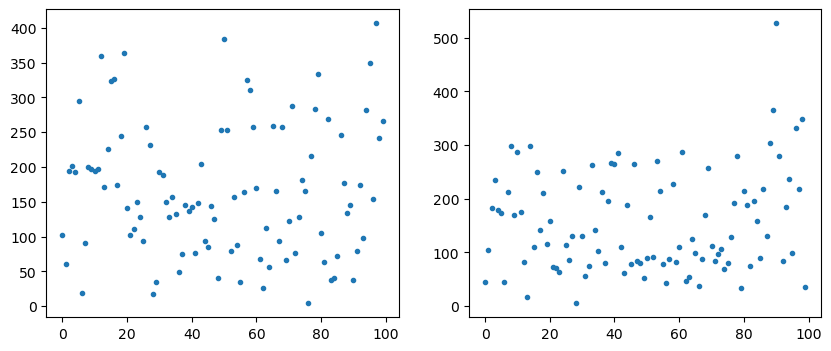

In [14]:
framesn = np.reshape(nSig, (nFrame, nShort), order='A')
nSFTs = np.fft.rfft(framesn, axis=1)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
plt.plot(shortFreq[:100], np.absolute(nSFTs[0, :100]), '.')
ax2 = fig.add_subplot(122)
plt.plot(shortFreq[:100], np.absolute(nSFTs[9, :100]), '.')

We are seeing a lot more useful energy at the relevant frequencies here. 

Applying the template I get

In [15]:
znsn = np.sum(templates.conjugate() * nSFTs, axis=1)
print(znsn)
totPowern = np.sum(znsn.conjugate() * znsn)
print(totPowern)

[413.52276179-148.1514899j  484.81875988 -16.88349717j
 322.99848826 +38.7764128j  514.14467409 -98.77787848j
 488.70845051-235.76315073j 498.96472473 -83.2869954j
 378.07017133-133.21669172j 380.83315443-110.95858622j
 744.20163801-135.02951022j 387.19484111 +85.34096427j]
(2405841.8152146987+2.787428451091025e-12j)


So there is a lot of noise but we have a very strong peak at this template.

If I do the same with the pure noise I get

In [21]:
noiseFrames = np.reshape(noise, (nFrame, nShort), order='A')
noiseSFTs = np.fft.rfft(noiseFrames, axis=1)
noisezns = np.sum(templates.conjugate() * noiseSFTs, axis=1)
print(noisezns)
totNoisePower = np.sum(noisezns.conjugate() * noisezns)
print(totNoisePower)
print(np.absolute(totPowern)/np.absolute(totNoisePower))

[ -86.47823858-148.1514899j   -15.18224054 -16.88349717j
 -177.0025122  +38.7764128j    14.14367358 -98.77787848j
  -11.29255006-235.76315073j   -1.03627591 -83.2869954j
 -121.93082938-133.21669172j -119.16784637-110.95858622j
  244.20063712-135.02951022j -112.80615989 +85.34096427j]
(292384.92456382903+1.3766702944907843e-12j)
8.22833741788726


So we have a signal/noise power ratio of about 8:1 compared to the 1:666 power ratio of the original signal to noise.

We can do the adjacent channel rejection test on the noisy signal too.

In [22]:
nSig1 = noise + sig1
framesn1 = np.reshape(nSig1, (nFrame, nShort), order='A')
n1SFTs = np.fft.rfft(framesn1, axis=1)
znsn1 = np.sum(templates.conjugate() * n1SFTs, axis=1)
print(znsn1)
totPowern1 = np.sum(znsn1.conjugate() * znsn1)
print(totPowern1)
print(np.absolute(totPowern1)/np.absolute(totNoisePower))

[ -85.47829199+171.71107316j  -16.18218389-336.78006666j
 -176.00257235+358.70836759j   13.14373755-418.746686j
  -10.29261819 +84.24407323j   -2.03620324-403.33430441j
 -120.93090701+186.87248544j -120.1677633 -431.09153982j
  245.20054807+185.14926531j -113.80606428-234.88582932j]
(1067882.3092873145-6.413843679157979e-12j)
3.6523165853381427


So we still have better than a factor of 2 adjacent channel rejection. This looks useful and moderately robust.

# Visualizing the Template Process

It may be instructive to look at the templating process as it affects the spectrograms. Let's start with the spectrogram for the basic signal.

AbsSpect 0:100
Data size (10, 100)


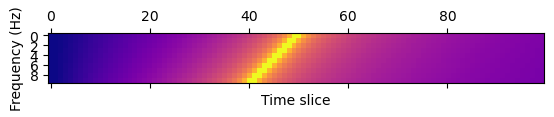

In [23]:
#
#   Helper for range-restricted plots
#
def _extractRange(plot_range):
    rmin = 0
    rmax = -1
    if plot_range is not None:
        if isinstance(plot_range, int):
            rmax = plot_range
        elif isinstance(plot_range, tuple):
            if not isinstance(plot_range[0], int):
                raise ValueError('Invalid plot range min')
            if not isinstance(plot_range[1], int):
                raise ValueError('Invalid plot range max')
            rmin = plot_range[0]
            rmax = plot_range[1]
    return (rmin, rmax)

def plotAbsSpectrogram(matrix, plot_range=None):
    gmin, gmax = _extractRange(plot_range)
    print(f'AbsSpect {gmin}:{gmax}')
    # iData = np.zeros((self.nFrame, self.nFreq))
    iData = np.zeros_like(matrix, dtype=float)
    # print(f'iData {nFreq}:{self.nFrame}')
    nfrm = matrix.shape[0]
    for i in range(nfrm):
        # iData[:, i] = np.absolute(matrix[:, i])
        iData[i, :] = np.absolute(matrix[i, :])
    print(f'Data size {iData[:, gmin:gmax].shape}')
#        ax.matshow(np.log10(iData[gmin:gmax, :] + 1.0e-10), cmap='plasma')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(iData[:, gmin:gmax], cmap='plasma', norm='log')
    ax.set_xlabel('Time slice')
    ax.set_ylabel('Frequency (Hz)')

plotAbsSpectrogram(SFTs, plot_range=(0,100))

AbsSpect 0:100
Data size (10, 100)


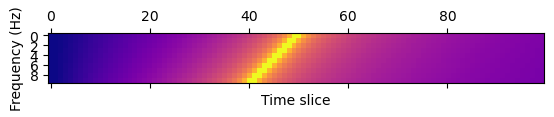

In [24]:
tFTs = templates.conjugate() * SFTs
plotAbsSpectrogram(tFTs, plot_range=(0,100))

Rather uninteresting. Do again with the real/imag version.

AbsSpect 0:100
AbsSpect 0:100


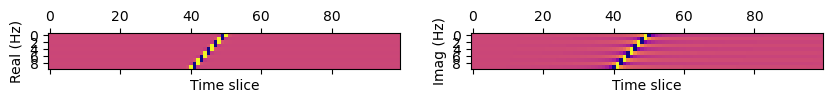

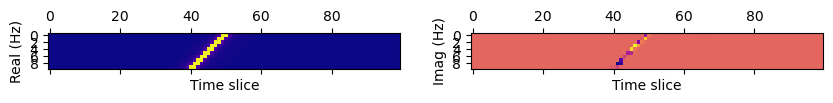

In [25]:
def plotRISpectrogram(matrix, plot_range=None):
    gmin, gmax = _extractRange(plot_range)
    print(f'AbsSpect {gmin}:{gmax}')
    # iData = np.zeros((self.nFrame, self.nFreq))
    iData = np.zeros_like(matrix, dtype=float)
    # print(f'iData {nFreq}:{self.nFrame}')
    nfrm = matrix.shape[0]
    for i in range(nfrm):
        # iData[:, i] = np.absolute(matrix[:, i])
        iData[i, :] = np.absolute(matrix[i, :])
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    # Real
    for i in range(nfrm):
        iData[i, :] = np.real(matrix[i, :])
    ax.matshow(iData[:, gmin:gmax], cmap='plasma')
    ax.set_xlabel('Time slice')
    ax.set_ylabel('Real (Hz)')
    #
    for i in range(nfrm):
        iData[i, :] = np.imag(matrix[i, :])
    ax1.matshow(iData[:, gmin:gmax], cmap='plasma')
    ax1.set_xlabel('Time slice')
    ax1.set_ylabel('Imag (Hz)')

plotRISpectrogram(SFTs, plot_range=(0,100))
plotRISpectrogram(tFTs, plot_range=(0,100))

There we see that we have indeed pushed most of the power into the real part of the spectrum, exactly as we wanted. The biggest effect is concentration of power from the horizontal stripes in the imaginary part of the SFT into the real part of the tFT.